# 04. Customer Risk Ranking

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/telco_churn.csv")
df['churn_flag'] = (df['Churn'] == "Yes").astype(int)

In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_flag
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


## Simple Churn Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Start with small, simple feature set
features = [
    "tenure",
    "MonthlyCharges"
]

X = df[features]
y = df["churn_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

df["churn_probability"] = model.predict_proba(X)[:, 1]


In [14]:
# Compute expected revenue loss
df["expected_revenue_loss"] = (
    df["churn_probability"] * df["MonthlyCharges"]
)

In [15]:
# Rank customers by risk
df_sorted = df.sort_values(
    "expected_revenue_loss",
    ascending=False
).reset_index(drop=True)

df_sorted.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_flag,churn_probability,expected_revenue_loss
0,5760-IFJOZ,Male,0,No,No,3,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,No,Mailed check,107.95,313.6,No,0,0.817965,88.299309
1,2081-VEYEH,Male,0,No,No,3,Yes,No,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,107.95,318.6,No,0,0.817965,88.299309
2,3992-YWPKO,Female,0,No,No,6,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Credit card (automatic),109.90,669.45,Yes,1,0.802914,88.240197
3,1583-IHQZE,Male,0,No,No,12,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Mailed check,112.95,1384.75,Yes,1,0.765232,86.432905
4,1400-MMYXY,Male,1,Yes,No,3,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,Yes,Electronic check,105.90,334.65,Yes,1,0.808069,85.574551


## Cumulative Revenue Risk

In [16]:
df_sorted["cumulative_revenue_risk"] = df_sorted[
    "expected_revenue_loss"
].cumsum()

total_risk = df_sorted["expected_revenue_loss"].sum()
df_sorted["cumulative_risk_share"] = (
    df_sorted["cumulative_revenue_risk"] / total_risk
)

df_sorted["customer_percentile"] = (
    (df_sorted.index + 1) / len(df_sorted)
)

df_sorted[[
    "customer_percentile",
    "cumulative_risk_share"
]].head()

,customer_percentile,cumulative_risk_share
0,0.000142,0.000641
1,0.000284,0.001283
2,0.000426,0.001924
3,0.000568,0.002552
4,0.000710,0.003173


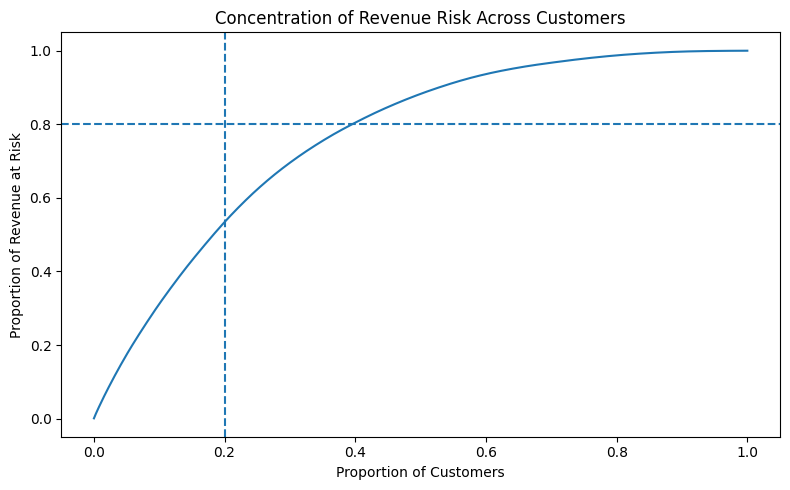

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    df_sorted["customer_percentile"],
    df_sorted["cumulative_risk_share"]
)
plt.axhline(0.8, linestyle="--")
plt.axvline(0.2, linestyle="--")
plt.xlabel("Proportion of Customers")
plt.ylabel("Proportion of Revenue at Risk")
plt.title("Concentration of Revenue Risk Across Customers")
plt.tight_layout()
plt.show()

## Insight

Revenue risk is somewhat concentrated, but not dominated by a very small subset of customers.
Approximately the top 20% of customers by expected revenue loss account for just over half of total revenue at risk, while capturing roughly 80% of risk requires targeting closer to 40% of customers.

This suggests that highly targeted retention strategies can improve efficiency, but overly narrow interventions may miss a substantial portion of revenue risk.